# Разработка стратегии взаимодействия с клиентами сети фитнес-центров «Культурист-датасаентист» на основе аналитических данных.

В наличии имеется множество клиентских анкет сети фитнес-центров «Культурист-датасаентист» в электронном виде. 

***Цель проекта***

Провести анализ данных и подготовить план действий по удержанию клиентов:

1)научиться прогнозировать вероятность оттока клиентов;

2)сформировать типичный портрет клиента;

3)проанализировать основные признаки, наиболее сильно влияющие на отток;

4)разработать рекомендации по повышению качества работы с клиентами.

## Загрузка данных

Импортируем данные. Изучим общую информацию в таблице и проверим корректность данных.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
server_path = '/datasets/gym_churn.csv' 
filename = 'gym_churn.csv'   
try:    
    data = pd.read_csv(server_path)     
except FileNotFoundError:   
    data = pd.read_csv(filename)

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# для удобства преобразуем название столбцов
data.columns = data.columns.str.lower()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Таблица **data** содержит 14 столбцов с информацией:

•	**gender** — пол (тип int64);

•	**near_location** — проживание или работа в районе, где находится фитнес-центр (тип int64);

•	**partner** — сотрудник компании-партнёра клуба  (тип int64);

•	**promo_friends** — факт первоначальной записи в рамках акции «приведи друга»  (тип int64);

•	**phone** — наличие контактного телефона(тип int64);

•	**contract_period** — длительность текущего действующего абонемента (тип int64).

•	**group_visits** — факт посещения групповых занятий (тип int64);

•	**age** — возраст (тип int64);

•	**avg_additional_charges_total** — суммарная выручка от других услуг фитнес-центра (тип float64);

•	**month_to_end_contract** — срок до окончания текущего действующего абонемента (тип float64);

•	**lifetime** — время с момента первого обращения в фитнес-центр (тип int64);

•	**avg_class_frequency_total** — средняя частота посещений в неделю за все время с начала действия абонемента (тип float64).

•	**avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц (тип float64);

•	**churn** — факт оттока в текущем месяце (тип int64)

Пропущенных данных в таблице нет, тип данных в каждом столбце соответствует находящейся в таблице информации, кроме столбца month_to_end_contract. Во всех названиях столбцов содержатся буквы одинакового регистра.

In [6]:
# в столбце month_to_end_contract целочисленные значения, преобразуем тип  
data['month_to_end_contract'] = data['month_to_end_contract'].astype('int64')

Проведем проверку данных на наличие дубликатов, используя метод duplicated()

In [7]:
print('Количество дубликатов в таблице data:', data.duplicated().sum())

Количество дубликатов в таблице data: 0


In [8]:
# проанализируем столбец gender
data['gender'].value_counts()

1    2041
0    1959
Name: gender, dtype: int64

Судя по информации внешних источников женщины чаще пользуются услугами фитнес-центров чем мужчины, поэтому логично предположить, что в данном датасете 1 - это женщины, 0 - мужчины, хотя и количество отличается незначительно.

### Вывод

Предоставленные данные о клиентах сети фитнес-центров «Культурист-датасаентист» корректно загружены. Пропущенных данных в таблице нет, тип данных в каждом столбце соответствует находящейся в таблице информации. Дубликатов в таблице нет. Произведена замена названий столбцов к нижнему регистру.

## Проведем исследовательский анализ данных (EDA)

Проанализируем таблицу, используя метод describe().

In [9]:
df = data.describe().T
df

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Анализируя полученные данные, сформируем описание типичного клиента фитнес-клуба. В 80% он живет или работает в том же районе, что и фитнес зал, ему примерно 29-32 года, в среднем имет контракт 6 месяцев и в среднем посещает фитнес 2 раза в неделю, хотя по данным есть любители попотеть и 6 дней в неделю. Чуть меньше половины клиентов клуба являются сотрудниками компании-партнера. Более 40% посещают групповые занятия, треть пришли с друзьями.

**Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Воспользуемся методом groupby().**

**Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)**

Посмотрим на категориальные переменные: gender, near_location, partner, promo_friends, phone, group_visits и целевую переменную churn. Проанализируем, какие из перечисленных переменных в большей степени влияют на отток.

In [10]:
# составим вспомогательную таблицу для визуализации категориальных переменных
category_parameters = data.groupby('churn').agg({'gender':'value_counts',
                                   'near_location': 'value_counts',
                                   'partner':'value_counts',
                                   'promo_friends':'value_counts',
                                   'phone':'value_counts',
                                   'group_visits':'value_counts'})
category_parameters.index.names = ['churn', 'value']
category_parameters = category_parameters.reset_index()
category_parameters

,churn,value,gender,near_location,partner,promo_friends,phone,group_visits
0,0,0,1440,373,1369,1900,283,1575
1,0,1,1499,2566,1570,1039,2656,1364
2,1,0,519,246,684,866,103,776
3,1,1,542,815,377,195,958,285


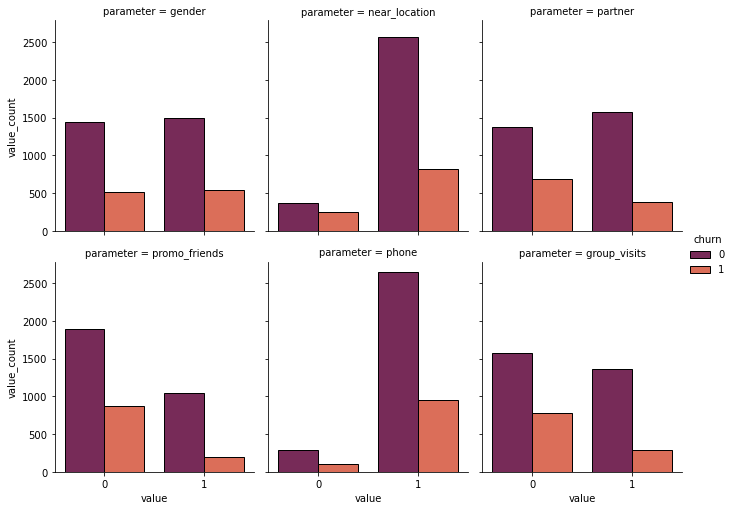

In [11]:
# увеличим уровни таблицы
category_parameters = category_parameters.set_index(['churn','value']).stack().reset_index(name='param')
category_parameters.columns = ['churn','value','parameter','value_count']


# для всех категориальных параметров строим гистограммы в разбивке по факту оттока
g = sns.catplot(x="value", y="value_count", col="parameter",
                hue="churn", data=category_parameters, kind="bar",col_wrap=3, palette="rocket", edgecolor='black',
                height=3.5, aspect=.9);


По графикам категориальных переменных кажется, что проживание или работа в другом районе, где находится фитнес-центр увеличивает шанс оттока посетителей. А также посещение групповых занятий намного меньше встречается у "отвалившихся", наверно этот параметр имеет влияние на отток.

Проанализируем количественные переменные: contract_period, age, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_current_month

Посмотрим на средние значения и стандартные отклонения для количественных параметров, а также отобразим распределение в разбивке на группы по параметру оттока.

count    4000.000000
mean        4.681250
std         4.549706
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: contract_period, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


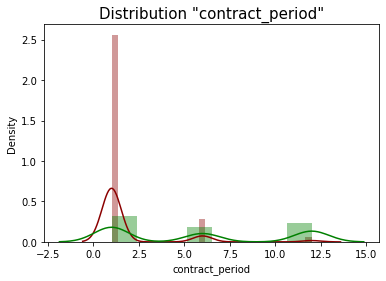

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


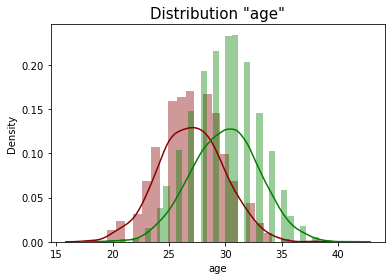

count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: avg_additional_charges_total, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


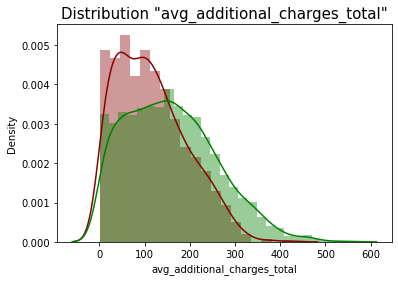

count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: month_to_end_contract, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


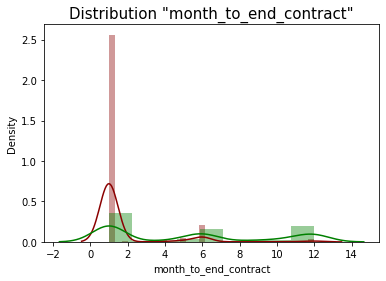

count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        31.000000
Name: lifetime, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


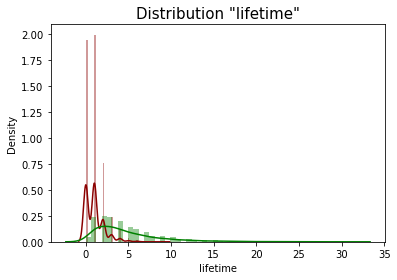

count    4000.000000
mean        1.879020
std         0.972245
min         0.000000
25%         1.180875
50%         1.832768
75%         2.536078
max         6.023668
Name: avg_class_frequency_total, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


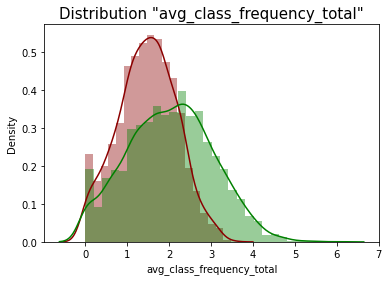

count    4000.000000
mean        1.767052
std         1.052906
min         0.000000
25%         0.963003
50%         1.719574
75%         2.510336
max         6.146783
Name: avg_class_frequency_current_month, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


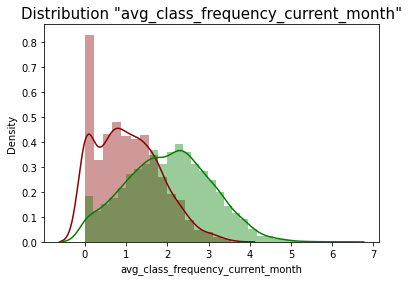

In [12]:
for val in ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract',
            'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    print(data[val].describe())
    sns.distplot(data[data['churn'] == 1][val], color="darkred");
    sns.distplot(data[data['churn'] == 0][val], color="green");
    plt.title('Distribution "{}"'.format(val), fontsize='15')
    plt.show()

Посмотрим на средние значения количественных параметров в двух группах — тех, кто ушел в отток и тех, кто остался

In [13]:
data.groupby('churn')['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract',
            'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month'].mean()

<ipython-input-13-92c550fab00b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby('churn')['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract',


,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,
0,5.747193,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1.728558,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Средние значения в группе тех, кто остался значительно больше чем в группе оттока.

**Построим матрицу корреляций и отобразим её.**

In [14]:
#вычисляем матрицу корреляций
cm = data.corr() 

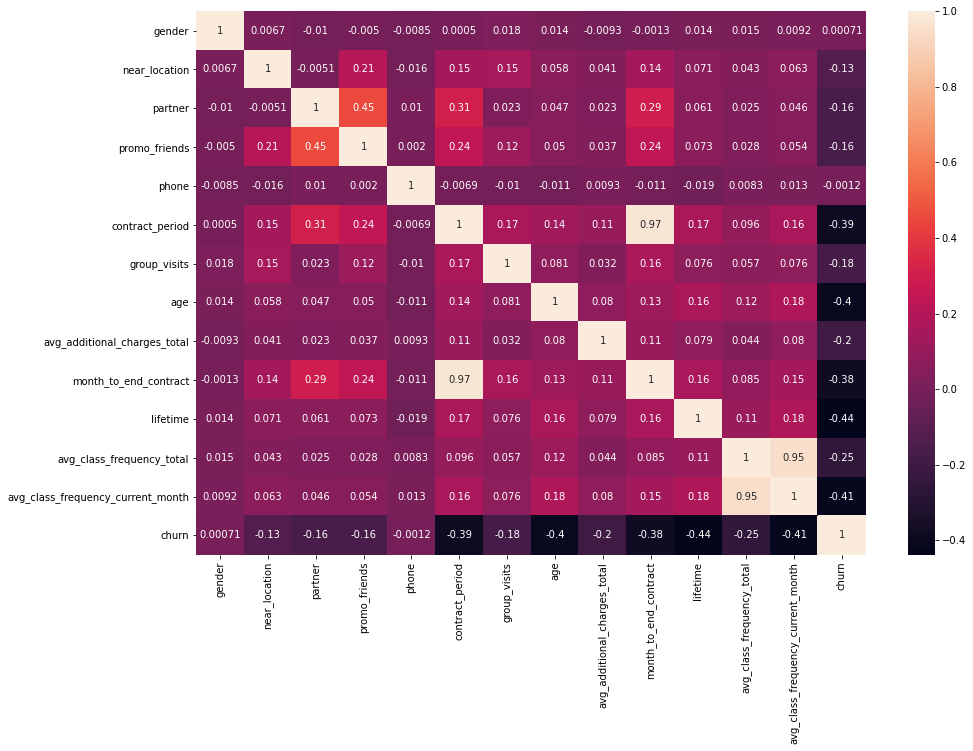

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot = True, square=False)

plt.show()

Видно, что отток пользователей обратно коррелирует с несколькими переменными. Это средняя частота посещений в неделю за предыдущий месяц, количество месяцев с момента первого посещения фитнес-центра, возраст и с периодом на который заключен договор. Если говорить о количестве месяцев до конца контракта, то считаю, что данная метрика связана с периодом договора. Это очень хорошо видно на тепловой карте. Корреляция у них достигает 97%.

### Вывод.

Отток совершенно точно не зависит от пола и оставленного номера телефона. 

По остальным признакам зависимость однозначно есть:

-По признаку живет или работает клиент в том же районе, где расположен фитнес-центр можно видеть, что неушедших пользователей живущих или работающих там же чуть больше. Очевидно, что это связано с удобством для клиента.

-Является ли клиент сотрудником компании партнера также различается для обеих групп. И тут все логично. Партнеры платят меньше.

-У ушедших абонемент взят на более короткий срок

-Опять же ушедшие пользователи чаще всего новые пользователи, поэтому время их "жизни" в зале даже не более единицы. Пришли, посмотрели, не понравилось, ушли.

-Не ушедшие пользователи чаще посещают групповые занятия.

-Ушедшие пользователи в среднем моложе и тратят меньше денег на дополнительные услуги.

-У тех, кто остается количество месяцев намного больше. Действительно, если пользователь решил покинуть зал в силу определенных причин, чаще всего он отходит весь свой абонемент и только потом бросит. У ушедших данный признак стремится к единице. То есть они дохаживают последний месяц.

-Ушедшие реже посещают зал.

## Построим модель прогнозирования оттока клиентов.

Построим модель машинного обучения для решения задачи классификации. Модель должна определять факт оттока посетителей по известным параметрам данных.

In [16]:
# Разобьем данные на тестовую и валидационную выборку
X = data.drop(columns = 'churn')
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [17]:
# стандартизация
scaler = StandardScaler() 
scaler.fit(X_train) # обучаем стандартизатор с помощью обучающей выборки
X_train_st = scaler.transform(X_train) # стандартизируем обучающую выборку
X_test_st = scaler.transform(X_test) # стандартизируем тестовую выборку

In [18]:
# функция для определения метрик качества модели
def metrics(y_true, y_pred):
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

**Логистическая регрессия**

In [19]:
# модель Логистической регресии 
model_LR = LogisticRegression()
# обучение модели 
model_LR.fit(X_train_st, y_train)
# прогноз на основе тестовой выборки
predictions_LR = model_LR.predict(X_test_st)

In [20]:
# метрики для модели Логической регресии
metrics(y_test, predictions_LR)

	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85
	F1: 0.87


На 94% модель выдает правильный ответ, метрика Accuracy показывает хороший результат. Модель правильно находит 85% пользвателей, которые действительно ушли в отток и также нашла 87% "отвалившихся".

**Случайный лес**

In [21]:
model_RF = RandomForestClassifier(n_estimators = 100, random_state=0)
# обучение модели 
model_RF.fit(X_train_st, y_train)
# прогноз на основе тестовой выборки
predictions_RF = model_RF.predict(X_test_st)

In [22]:
# метрики для модели случайного леса
metrics(y_test, predictions_RF)

	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	F1: 0.85


Случайный лес дает более слабый результат по метрикам, чем логистическая регрессия.

### Вывод.

Данные разбиты на тестовую и валидационную выборки, проведена стандартизация данных. Построена модель бинарной классификации клиентов. Обучена двумя способами - логистической регрессией и случайным лесом. Оценка метрик accuracy, precision и recall для обеих моделей показала, что медель Логистической регрессии дает более точный и качественный результат.

## Сделаем кластеризацию клиентов

Проведем кластеризацию имеющихся данных.

In [23]:
# стандартизаця
churn_scaler = scaler.fit_transform(data.drop(columns='churn'))

Пострим матрицу расстояний на стандартизованных данных и нарисуем дендрограмму

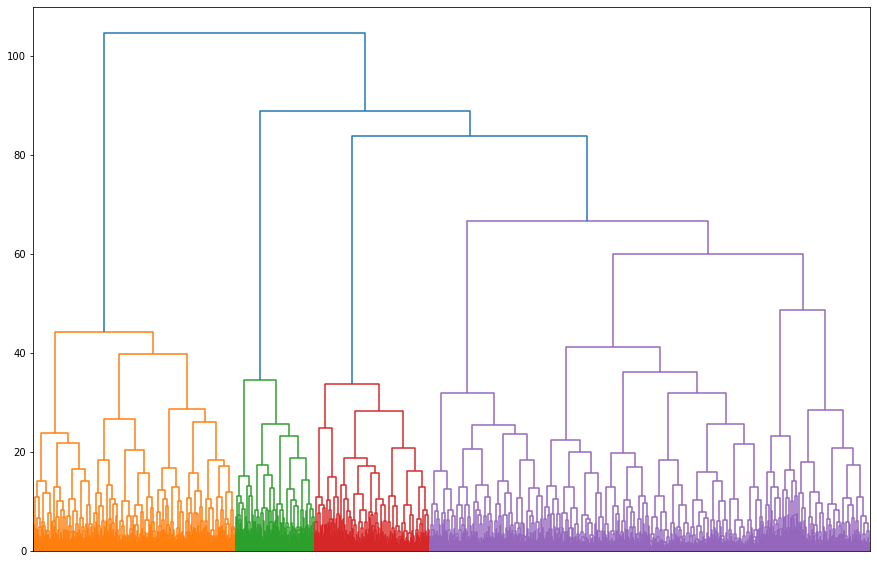

In [24]:
linked = linkage(churn_scaler, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, no_labels=True)
plt.show() 

За число кластеров примем n=5. Применим к модели алгоритм кластеризации K-Means и спрогнозируем кластеры клиентов

In [25]:
# задаем модель K-means
km = KMeans(n_clusters = 5, random_state=0)
#  формируем вектор кластеров
labels = km.fit_predict(churn_scaler)
# сохраним метки кластеров в данных
data['claster'] = labels

Кластеризация проведена. Посмотрим на средние значения признаков для каждого кластера.

In [26]:
data.groupby('claster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
claster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Построим для всех категориальных параметров визуализацию в разбивке по кластерам.

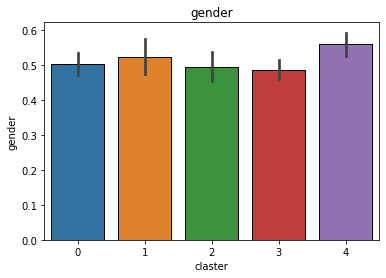

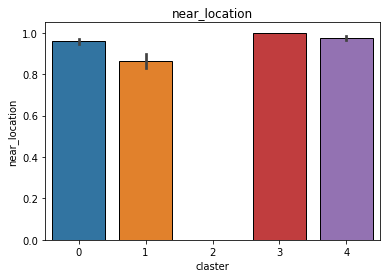

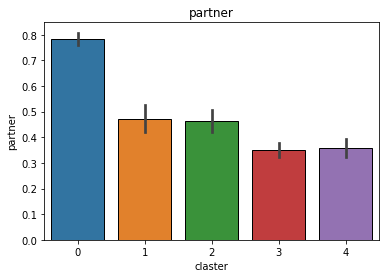

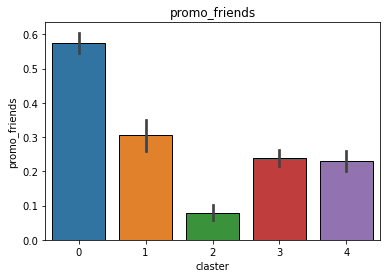

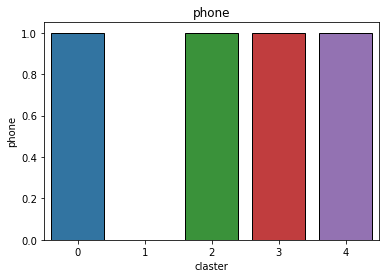

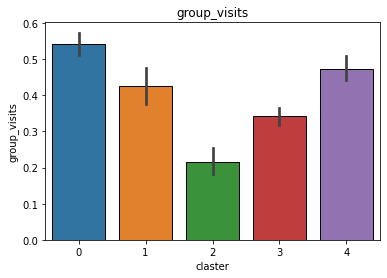

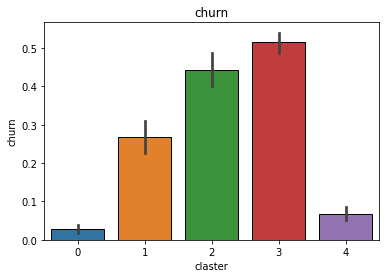

In [27]:
for i in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']:
    sns.barplot(data=data, x='claster',y=i, edgecolor='black');
    plt.title(i)
    plt.show()

На гистограммах изображен % положительных значений среди категориальных признаков в разбивке по кластерам. Видно, что некоторые признаки влияют намного сильнее других, как например посещение групповых занятий. Также факт первоначальной записи в рамках акции «приведи друга» сильнее всего выражен на кластере, который меньше всего по количеству оттока клиентов. Люди, кторые не посещают групповые занятия вероятнее всего уйдут в отток. Также наличие факта первоначальной записи в рамках акции «приведи друга» повышает шансы на то что клиент останется надолго.

Построим гистограммы для числовых параметров в разбивке по кластерам

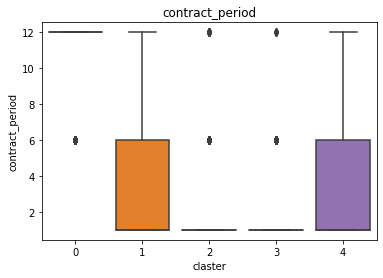

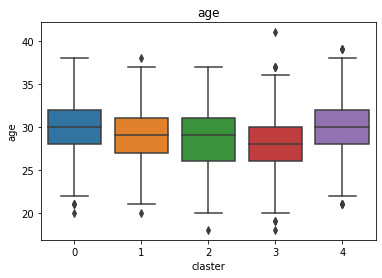

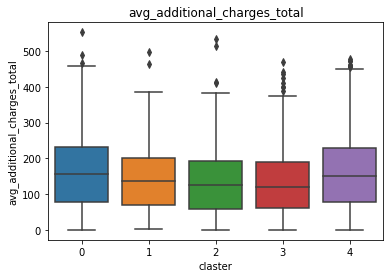

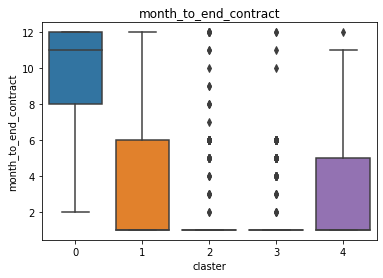

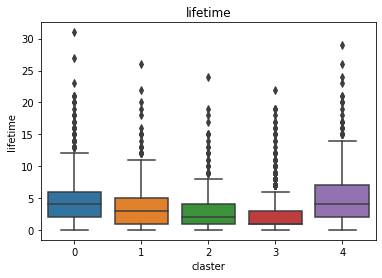

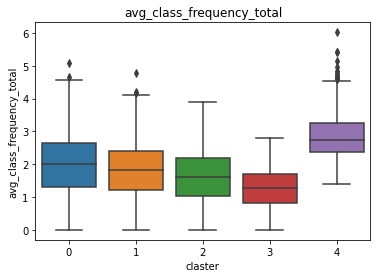

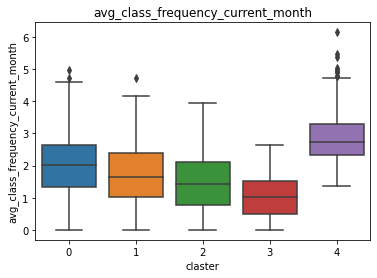

In [28]:
for val in ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract',
            'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    sns.boxplot(data=data, x='claster',y=val);
    plt.title(val)
    plt.show()

По распределению количественных параметров видно, что более молодые чаще уходят в отток. Также чем меньше у клиента время с момента первого обращения в фитнес в месяцах, тем более вероятно, что он уйдет в отток. И люди, у которых заканчивается контракт в основном уходят на совсем. Также люди которые часто посещают фитнес (2-3 раза в неделю) менее подвержены оттоку.

## Вывод

Проанализировав полученные данные, можно сформировать описание типичного клиента фитнес-клуба.

-в 80% он живет или работает в том же районе, что и фитнес зал; 

-ему примерно 29-32 года;

-в среднем контракт заключается на 6 месяцев;

-среднее количество посещений 2 раза в неделю; 

-меньше половины клиентов клуба являются сотрудниками компании-партнера;

-более 40% посещают групповые занятия;

-треть пришли с друзьями.

В проекте построено две модели прогнозирования оттока клиентов, логистическая регрессия и случайный лес. При этом логистическая регрессия показывает более точный и качественный результат. Для набора данных проведена кластеризация с разбиением на 5 кластеров, которая показала, что наиболее влиятельными на отток клиентов являются такие признаки как: посещение групповых занятий, среднее количество посещений клуба в неделю, факт первоначальной записи в рамках акции «приведи друга», а также время с момента первого обращения в фитнес-центр (в месяцах) и количество месяцев до окончания контракта. Более молодые посетители клуба чаще подвержены оттоку - фитнес-клубу стоит усилить рекламу для лиц с возрастом. Также если стоит задача минимизировать отток, то стоит рассмотреть повышение цен для новичков клуба. Стоит разнообразить программы групповых занятий, чтобы каждый член клуба смог найти себе подходящую группу - это также позволит увеличить среднее количество посещений в неделю.